<a href="https://colab.research.google.com/github/harshit-coder-dev/ML-projects/blob/master/Food_Delivery_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Delivery Time Prediction

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

Load Dataset

In [2]:
import pandas as pd
df = pd.read_csv('/content/Food_Delivery_Time_Prediction.csv')
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

Extract Latitude & Longitude

In [4]:
df[['Cust_Lat', 'Cust_Long']] = df['Customer_Location'].str.strip('()').str.split(',', expand=True).astype(float)
df[['Rest_Lat', 'Rest_Long']] = df['Restaurant_Location'].str.strip('()').str.split(',', expand=True).astype(float)

Recalculate Distance — Feature Engineering

In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*asin(sqrt(a))

df['Calculated_Distance'] = df.apply(lambda x: haversine(x.Cust_Lat, x.Cust_Long, x.Rest_Lat, x.Rest_Long), axis=1)

In [6]:
df.isnull().sum()

,0
Order_ID,0
Customer_Location,0
Restaurant_Location,0
Distance,0
Weather_Conditions,0
Traffic_Conditions,0
Delivery_Person_Experience,0
Order_Priority,0
Order_Time,0
Vehicle_Type,0


Create Time-Based Feature

In [7]:
df['Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if x in ['Evening', 'Night'] else 0)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

In [13]:
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,...,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Cust_Lat,Cust_Long,Rest_Lat,Rest_Long,Calculated_Distance,Rush_Hour
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,...,3.0,26.22,1321.10,81.54,17.030479,79.743077,12.358515,85.100083,775.651198,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,...,4.2,62.61,152.21,29.02,15.398319,86.639122,14.174874,77.025606,1042.385597,1
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,...,3.4,48.43,1644.38,64.17,15.687342,83.888808,19.594748,82.048482,476.220706,1
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,...,3.7,111.63,541.25,79.23,20.415599,78.046984,16.915906,78.278698,389.912629,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,...,2.8,32.38,619.81,2.34,14.786904,78.706532,15.206038,86.203182,806.505886,1


As distance column dont have null values so we drop calculated distance

One hot encoding

In [14]:
X = df.drop([
    'Delivery_Time',
    'Order_ID',
    'Customer_Location',
    'Restaurant_Location',
    'Calculated_Distance',
    'Cust_Lat','Cust_Long','Rest_Lat','Rest_Long'
], axis=1)
y = df['Delivery_Time']
num_cols = X.select_dtypes(include= np.number).columns
cat_cols = X.select_dtypes(include=['object']).columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

Descriptive Statistics

In [15]:
df.describe()

,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Cust_Lat,Cust_Long,Rest_Lat,Rest_Long,Calculated_Distance,Rush_Hour
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,11.498050,5.250000,3.738500,3.686500,70.494950,1046.488700,46.616650,16.997762,82.478466,16.675150,82.579902,603.037915,0.510000
std,6.841755,2.745027,0.703021,0.697063,29.830694,548.568922,29.361706,3.097039,3.151669,2.837942,3.286385,269.796797,0.501154
min,0.520000,1.000000,2.500000,2.600000,15.230000,122.300000,1.240000,12.021992,77.018445,12.019922,77.010580,29.871927,0.000000
25%,6.090000,3.000000,3.200000,3.100000,46.997500,553.270000,21.602500,14.368618,79.700913,14.171155,79.617649,389.197293,0.000000
50%,10.265000,5.000000,3.800000,3.700000,72.775000,1035.950000,47.530000,17.081582,82.271895,16.516376,82.482346,558.788921,1.000000
75%,16.497500,8.000000,4.300000,4.300000,96.650000,1543.125000,70.245000,20.091919,85.400211,18.829646,85.628492,807.602442,1.000000
max,24.900000,10.000000,5.000000,5.000000,119.670000,1997.420000,99.740000,21.941596,87.968582,21.990214,87.896124,1299.244267,1.000000


Correlation Analysis

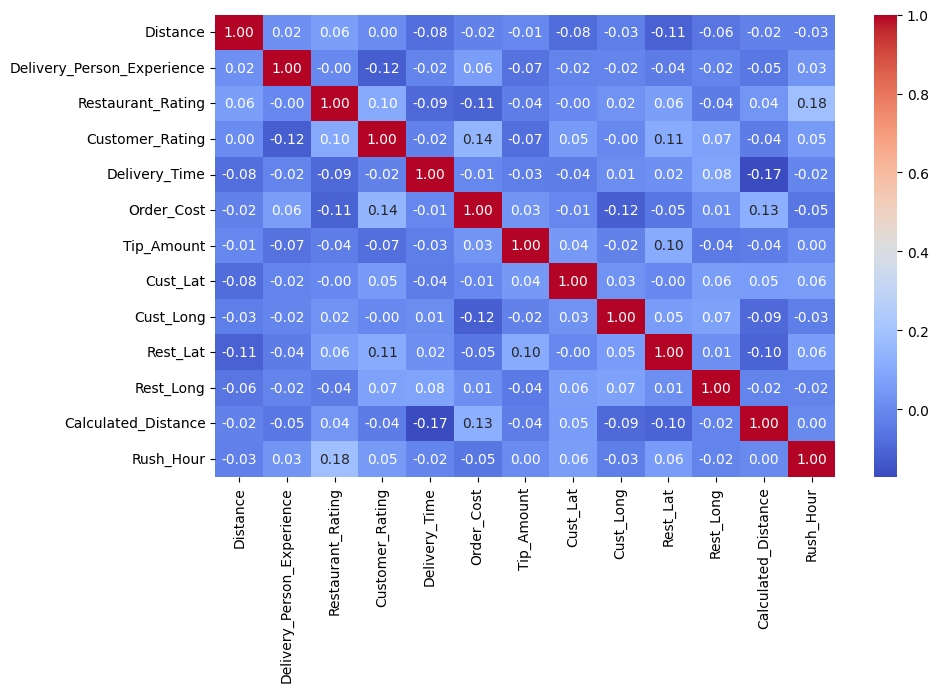

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt= '.2f')
plt.show()

Outlier Detection

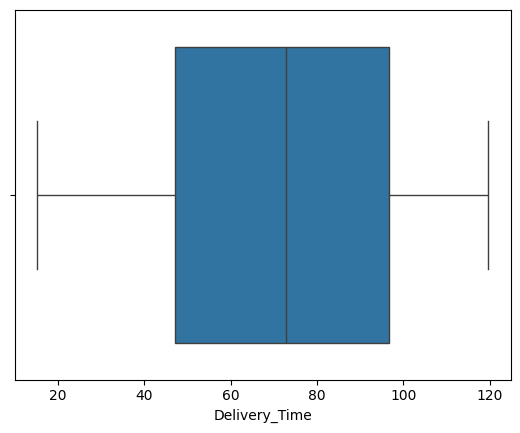

In [17]:
sns.boxplot(x=df['Delivery_Time'])
plt.show()

Train–Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Build Model Pipeline (Pipeline = Preprocessing + Model in one flow)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lin_model = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

Train Model

In [20]:
lin_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating',
       'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Rush_Hour'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority',
       'Order_Time', 'Vehicle_Type'],
      dtype='object'))])),
                ('model', LinearRegression())])

Predictions

In [21]:
y_pred = lin_model.predict(X_test)

Evaluate Regression Model

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 1021.9359676315064
MAE: 27.184522740542167
R² Score: -0.104925592549449


Visual Check

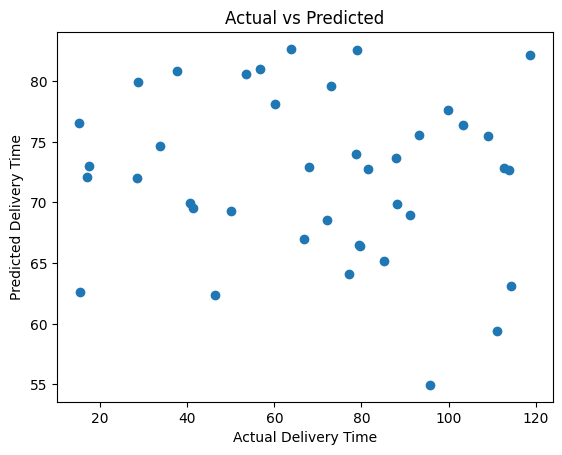

In [23]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Actual vs Predicted")
plt.show()

LOGISTIC REGRESSION (Fast vs Delayed)

Create Delivery Status

In [24]:
df['Delivery_Status'] = df['Delivery_Time'].apply(
    lambda x: 1 if x > df['Delivery_Time'].median() else 0
)

Prepare Data Again

In [25]:
X_class = X.copy()
y_class = df['Delivery_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

Logistic Model Pipeline

In [26]:
from sklearn.linear_model import LogisticRegression

log_model = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression())
])

log_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating',
       'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Rush_Hour'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority',
       'Order_Time', 'Vehicle_Type'],
      dtype='object'))])),
                ('model', LogisticRegression())])

Classification Metrics

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.4
Precision: 0.43478260869565216
Recall: 0.47619047619047616
F1 Score: 0.45454545454545453


Confusion Matrix

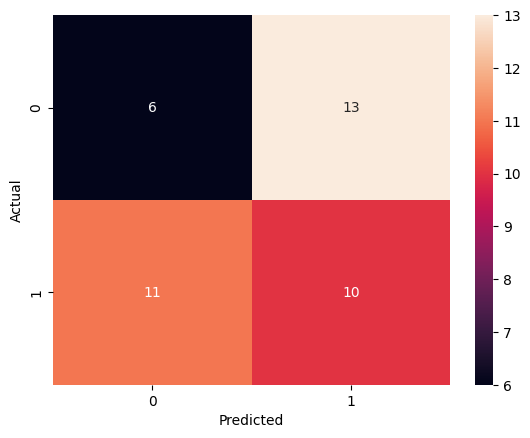

In [28]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()